In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

#import the noise packages
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error,amplitude_damping_error,phase_damping_error,phase_amplitude_damping_error
from qiskit.providers.aer.noise import thermal_relaxation_error


from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def get_noise(p_bit,p_phase,p_gate1,p_gate2):
    bit_flip = pauli_error([('X',p_bit), ('I', 1 - p_bit)])#bit flip
    phase_flip = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])#phase flip
    #bitphase_flip = phase_flip.compose(phase_flip)
    #error_gate1 = depolarizing_error(p_gate, 1)
    #error_gate2=amplitude_damping_error(p_gate, excited_state_population=0, canonical_kraus=True)
    #error_gate3=phase_damping_error(p_gate, canonical_kraus=True)
    error_gate4=phase_amplitude_damping_error(p_gate1, p_gate2, excited_state_population=0, canonical_kraus=True)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(phase_flip, "measure") # measurement error is applied to measurements
    #noise_model.add_all_qubit_quantum_error(error_gate4, ["x","h"]) # single qubit gate error is applied to x gates
        
    return noise_model


In [4]:
#Give the proper parameter
noise_model = get_noise(0.05,0.05,0.05,0.05)  

In [5]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [6]:
quantum_instance2 = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024, noise_model=noise_model)

In [7]:
# callback function that draws a live plot when the .fit() method is called

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [57]:
from sklearn import datasets
from sklearn.decomposition import PCA


iris = datasets.load_iris()
x = iris.data
y = iris.target

X = np.concatenate((x[:40], x[50:90]))

y_one_hot = np.array([[1,0]])
for i in range(39):
  y_one_hot = np.concatenate((y_one_hot, [[1,0]]))

for i in range(40):
  y_one_hot = np.concatenate((y_one_hot, [[0,1]]))

In [51]:
#Data_forTest

iris = datasets.load_iris()
x = iris.data
y = iris.target

X = np.concatenate((x[:40], x[50:90]))

y_one_hot = np.array([[1,0]])
for i in range(39):
  y_one_hot = np.concatenate((y_one_hot, [[1,0]]))

for i in range(40):
  y_one_hot = np.concatenate((y_one_hot, [[0,1]]))

In [64]:
x_test = np.concatenate((x[40:50], x[90:100]))
x_test.shape

(20, 4)

In [65]:
d = [[1] for _ in range(4)]
for i in x_test:
    for j in range(4):
        d[j].append(i[j])

for i in range(4):
    d[i].pop(0)
len(d)

4

In [66]:
df = pd.DataFrame({'1': np.array(d[0]), '2': np.array(d[1]), '3': np.array(d[2]), '4': np.array(d[3]), 'result': np.concatenate((y[40:50], y[90:100]))})
df

,1,2,3,4,result
0,5.0,3.5,1.3,0.3,0
1,4.5,2.3,1.3,0.3,0
2,4.4,3.2,1.3,0.2,0
3,5.0,3.5,1.6,0.6,0
4,5.1,3.8,1.9,0.4,0
5,4.8,3.0,1.4,0.3,0
6,5.1,3.8,1.6,0.2,0
7,4.6,3.2,1.4,0.2,0
8,5.3,3.7,1.5,0.2,0
9,5.0,3.3,1.4,0.2,0


In [55]:
# construct feature map, ansatz, and optimizer

num_inputs = 2

feature_map = ZZFeatureMap(num_inputs, reps=2, entanglement='full')

ansatz = RealAmplitudes(num_inputs, reps=1)


In [41]:
print(feature_map)

     ┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘


In [42]:
print(ansatz)

     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘


In [58]:
d = [[1] for _ in range(4)]
for i in X:
    for j in range(4):
        d[j].append(i[j])

for i in range(4):
    d[i].pop(0)

In [59]:
import pandas as pd
df = pd.DataFrame({'1': np.array(d[0]), '2': np.array(d[1]), '3': np.array(d[2]), '4': np.array(d[3]), 'result': np.concatenate((y[:40], y[50:90]))})

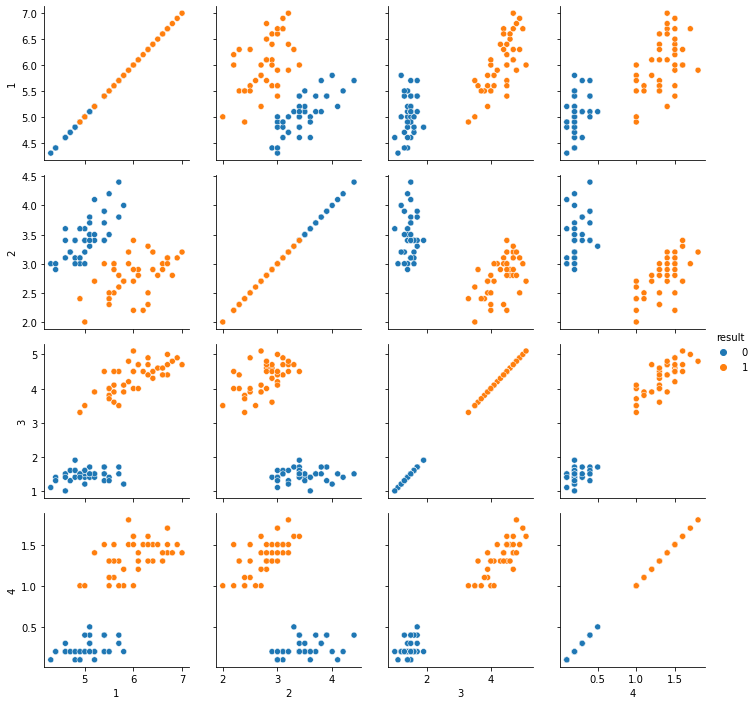

In [60]:
import seaborn as sns
pair_plot = sns.PairGrid(df, hue = 'result')
pair_plot.map(sns.scatterplot)
pair_plot.add_legend()

In [61]:
# construct variational quantum classifier

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=1000, tol=0.001),
    quantum_instance=quantum_instance2,
    callback=callback_graph,
)

In [62]:
data = df[['3', '4']] #3, 4 - 2, 1 - 4, 2
var = np.array(data)

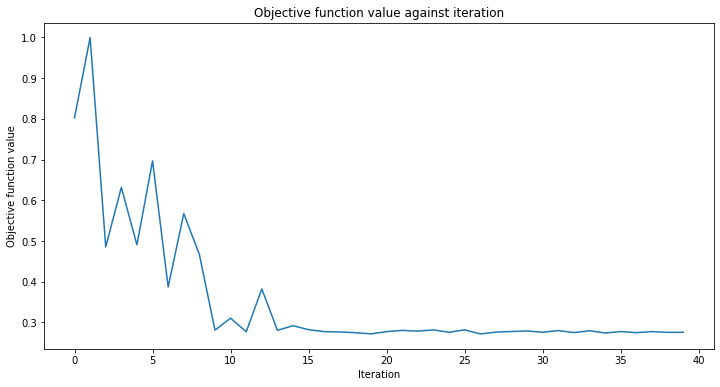

0.95
The time of execution of above program is : 66.21792435646057 sec


In [63]:
# create empty array for callback to store evaluations of the objective function

# Import time module
import time
 # record start time
start = time.time()


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(var, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print(vqc.score(var, y_one_hot))

# record end time
end = time.time()
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      ((end-start) * 10**3)/1000, "sec")

In [47]:
X_test = np.concatenate((X[40:50], X[90:100]))
X_test

y_one_hot_test = np.array([[1,0]])
for i in range(9):
  y_one_hot_test = np.concatenate((y_one_hot_test, [[1,0]]))

for i in range(10):
  y_one_hot_test = np.concatenate((y_one_hot_test, [[0,1]]))

y_one_hot_test.shape

(20, 2)

In [49]:
X_test

array([[7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.3, 4. , 1.3],
       [6.5, 2.8, 4.6, 1.5],
       [5.7, 2.8, 4.5, 1.3],
       [6.3, 3.3, 4.7, 1.6],
       [4.9, 2.4, 3.3, 1. ],
       [6.6, 2.9, 4.6, 1.3],
       [5.2, 2.7, 3.9, 1.4]])

In [44]:
d = [[1] for _ in range(4)]
for i in X_test:
    for j in range(4):
        d[j].append(i[j])

for i in range(4):
    d[i].pop(0)

df_test = pd.DataFrame({'1': np.array(d[0]), '2': np.array(d[1]), '3': np.array(d[2]), '4': np.array(d[3]), 'result': np.concatenate((y[40:50], y[90:100]))})

Traceback (most recent call last):
  Input In [44] in <cell line: 9>
    df_test = pd.DataFrame({'1': np.array(d[0]), '2': np.array(d[1]), '3': np.array(d[2]), '4': np.array(d[3]), 'result': np.concatenate((y[40:50], y[90:100]))})
  File /opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:614 in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
  File /opt/conda/lib/python3.8/site-packages/pandas/core/internals/construction.py:464 in dict_to_mgr
    return arrays_to_mgr(
  File /opt/conda/lib/python3.8/site-packages/pandas/core/internals/construction.py:119 in arrays_to_mgr
    index = _extract_index(arrays)
  File /opt/conda/lib/python3.8/site-packages/pandas/core/internals/construction.py:635 in _extract_index
    raise ValueError("All arrays must be of the same length")
ValueError: All arrays must be of the same length

Use %tb to get the full traceback.


In [90]:
data = df[['1', '2']] #3, 4 - 2, 1 - 4, 2
var = np.array(data)

In [93]:
var

array([[5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3],
       [5.5, 2.6],
       [6.1, 3. ],
       [5.8, 2.6],
       [5. , 2.3],
       [5.6, 2.7],
       [5.7, 3. ],
       [5.7, 2.9],
       [6.2, 2.9],
       [5.1, 2.5],
       [5.7, 2.8]])

In [91]:
# evaluate data points
y_predict = vqc.predict(var)
y_predict.shape

(20, 2)

In [78]:
y_one_hot = np.array([[1,0]])
for i in range(9):
  y_one_hot = np.concatenate((y_one_hot, [[1,0]]))

for i in range(10):
  y_one_hot = np.concatenate((y_one_hot, [[0,1]]))

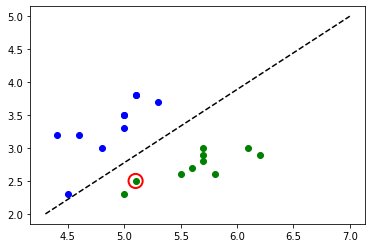

<Figure size 432x288 with 0 Axes>

In [86]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(x_test, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([4.3, 7], [2, 5], "--", color="black")
plt.show()
plt.savefig('output1.png')

In [92]:
print(vqc.score(var, y_one_hot))

0.95


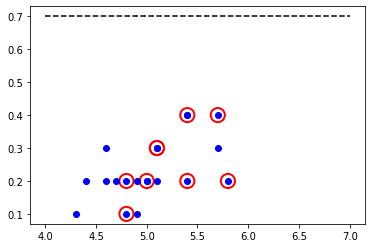

In [73]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[3], "bo")
    else:
        plt.plot(x[0], x[3], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[3], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([4, 7], [0.7, 0.7], "--", color="black")
plt.show()

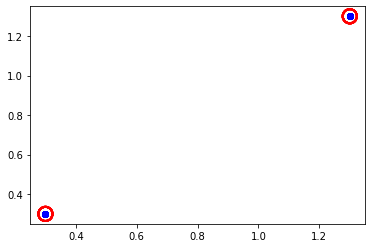

In [74]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(var, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(var[0], var[1], "bo")
    else:
        plt.plot(var[0], var[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(var[0], var[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
#plt.plot([4.3, 7], [2, 5], "--", color="black")
plt.show()

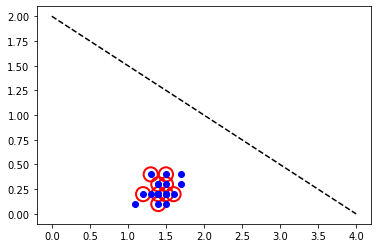

In [75]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[2], x[3], "bo")
    else:
        plt.plot(x[2], x[3], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[2], x[3], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([0, 4], [2, 0], "--", color="black")
plt.show()